<a href="https://colab.research.google.com/github/gokulkolady/lyrec_nlp/blob/main/valence_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf lyrec_nlp
git clone https://github.com/gokulkolady/lyrec_nlp.git

Cloning into 'lyrec_nlp'...


In [ ]:
# Imports
import sys
sys.path.append("/content/lyrec_nlp")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle
import random

import numpy as np
import re
import string

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
# Create tfidf classes
MIN_OCCUR = 100
MAX_OCCUR = 3000

class Tokenizer:
  def __init__(self, min_occur=MIN_OCCUR, max_occur=MAX_OCCUR):
    self.word_to_token = {}
    self.token_to_word = {}
    self.word_count = {}

    self.word_to_token['<unk>'] = 0
    self.token_to_word[0] = '<unk>'
    self.vocab_size = 1

    self.min_occur = min_occur
    self.max_occur = max_occur

  def fit(self, corpus):
    for review in corpus:
      words = review.split()
      for word in words:
          if word not in self.word_count:
              self.word_count[word] = 0
          self.word_count[word] += 1

    for review in corpus:
      words = review.split()
      for word in words:
        if self.word_count[word] < self.min_occur:
          continue
        if self.word_count[word] > self.max_occur:
          continue
        if word in self.word_to_token:
          continue
        self.word_to_token[word] = self.vocab_size
        self.token_to_word[self.vocab_size] = word
        self.vocab_size += 1

  def tokenize(self, corpus):
    tokenized_corpus = []
    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", review)
      tokenized_review = []
      for word in words:
        if word not in self.word_to_token:
          tokenized_review.append(0)
        else:
          tokenized_review.append(self.word_to_token[word])
      tokenized_corpus.append(tokenized_review)
    return tokenized_corpus

  def de_tokenize(self, tokenized_corpus):
    corpus = []
    for tokenized_review in tokenized_corpus:
      review = []
      for token in tokenized_review:
        review.append(self.token_to_word[token])
      corpus.append(" ".join(review))
    return corpus


class CountVectorizer:
  def __init__(self, min_occur=MIN_OCCUR, max_occur=MAX_OCCUR):
    self.tokenizer = Tokenizer(min_occur, max_occur)

  def fit(self, corpus):
    self.tokenizer.fit(corpus)

  def transform(self, corpus):
    n = len(corpus)
    X = np.zeros((n, self.tokenizer.vocab_size))
    for i, review in enumerate(corpus):
      words = review.split()
      for word in words:
        if word not in self.tokenizer.word_count or self.tokenizer.word_count[word] < self.tokenizer.min_occur or self.tokenizer.word_count[word] > self.tokenizer.max_occur:
          X[i][0] += 1
        else:
          X[i][self.tokenizer.word_to_token[word]] += 1
    return X

def get_ngrams(tokenized_corpus, window_size, pad_idx=2006):
    ngrams = []
    for i, review in enumerate(tokenized_corpus):
        for j, word in enumerate(review):
            min_ind = max(0, j-window_size)
            max_ind = min(len(review), j+window_size+1)
            ctx = np.zeros(2 * window_size, dtype=np.int64) + pad_idx
            for ik, k in enumerate(range(min_ind, j)):
                ctx[ik] = review[k]
            for ik, k in enumerate(range(j+1, max_ind)):
                ctx[window_size+ik] = review[k]
            ngrams.append((ctx, review[j]))
    return ngrams

def transform_tfidf(matrix, idf=None, evaluation=False):
    # `matrix` is a `|V| x |D|` TD matrix of raw counts, where `|V|` is the 
    # vocabulary size and `|D|` is the number of documents in the corpus. This
    # function should return a version of `matrix` with the TF-IDF transform
    # applied. Note: this function should be nondestructive: it should not
    # modify the input; instead, it should return a new object.
    if not evaluation:
        return matrix * (np.log(matrix.shape[1]/(np.count_nonzero(matrix, axis=1, keepdims=True)))), (np.log(matrix.shape[1]/(np.count_nonzero(matrix, axis=1, keepdims=True))))
    else:
        return matrix * idf

In [ ]:
# Load data for tfidf processing from pickle
all_data = []

with open('/content/lyrec_nlp/unique_song_dataset.pkl', 'rb') as f:
    all_data = pickle.load(f)

# with open('/content/lyrec_nlp/10000_song_dataset.pkl', 'rb') as f:
#     all_data += pickle.load(f)

all_data = [internal[0] for internal in all_data]
lyric_data = [internal[2] for internal in all_data]

# Create Term Document matrix
vectorizer = CountVectorizer()
vectorizer.fit(lyric_data)
td_matrix = vectorizer.transform(lyric_data).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")
print(vectorizer.tokenizer.word_count)

# Convert to TF-IDF matrix
td_matrix_tfidf, idf = transform_tfidf(td_matrix)
print(idf.shape)

# from gensim.scripts.glove2word2vec import glove2word2vec

# #glove_input_file = glove_filename
# glove_filename='glove.6B.300d.txt'
# word2vec_output_file = glove_filename+'.word2vec'
# glove2word2vec("/content/lyrec_nlp/" + glove_filename, word2vec_output_file)

# from gensim.models import KeyedVectors
# # load the Stanford GloVe model
# word2vec_output_file = glove_filename+'.word2vec'
# model = KeyedVectors.load_word2vec_format(word2vec_output_file)

# print('King: ',model.get_vector('an'))



# Append tfidf vectors to all_data
for c in range(len(all_data)):
  all_data[c].append(td_matrix_tfidf[:,c].tolist())

TD matrix is 2053 x 9159
{'номер': 21, '1': 298, 'я': 652, 'не': 485, 'победим': 4, 'забираю': 4, 'тренды': 4, 'никому': 9, 'обойти': 4, 'брюлики': 4, 'танцуют': 4, 'на': 346, 'запястье': 5, 'и': 236, 'цепи': 6, 'салют': 5, 'yt': 4, 'хах': 2, 'сумка': 1, 'louis': 94, 'v': 93, 'три': 15, 'тысячи': 4, 'бачей': 1, 'зайдя': 1, 'канал': 1, 'ты': 212, 'наблюдаешь': 1, 'богачей': 1, 'audemars': 11, 'piguet': 4, 'всё': 80, 'это': 177, 'мне': 203, 'притворяюсь': 1, 'бедным': 1, 'типа': 2, 'такой': 8, 'как': 132, 'даже': 16, 'недавно': 1, 'помню': 4, 'заходил': 1, 'в': 400, 'метро': 5, 'чтобы': 21, 'посмотреть': 1, 'баннер': 1, 'со': 30, 'своим': 3, 'лицом': 1, 'салютую': 1, 'fanta': 11, 'цвета': 3, 'будто': 35, 'lambo': 63, 'у': 65, 'большого': 1, 'мальчика': 1, 'огромные': 1, 'контракты': 1, 'школьники': 1, 'достали': 1, 'постоянно': 1, 'меня': 80, 'палят': 1, 'улетел': 3, 'от': 29, 'них': 6, 'бизнес-классом': 1, 'бали': 1, 'девочка': 12, 'моя': 21, '—': 177, 'красотка': 4, 'тоже': 3, 'популяр

In [ ]:
processed_embeddings = []
common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
common_word = set(common_word.split(" "))
removed_index = set()
for index in range(len(lyric_data)):
  song = lyric_data[index]
  words = song.split(" ")
  embedding = np.zeros(300)
  word_counter = 0
  non_vocab_counter = 0
  for word in words:
    if word not in common_word:
      try:
        word_embedding = model.get_vector(word)
        embedding += word_embedding
        word_counter += 1
      except:
        non_vocab_counter += 1
  if word_counter != 0:
    embedding = embedding/word_counter
  processed_embeddings.append(embedding)
  if non_vocab_counter>word_counter:
    removed_index.add(index)


print('King: ',model.get_vector('love'))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(type(vectorizer.tokenizer.word_count))
print(sorted( ((v,k) for k,v in vectorizer.tokenizer.word_count.items()), reverse=True))
print(sorted( ((v,k) for k,v in vectorizer.tokenizer.word_count.items())))


<class 'dict'>
[(66360, 'the'), (62551, 'i'), (53296, 'you'), (38770, 'a'), (35838, 'to'), (34123, 'and'), (31339, 'me'), (25857, 'my'), (25622, 'in'), (21230, 'it'), (18049, 'of'), (17351, 'on'), (15906, 'that'), (15435, 'your'), (14889, "i'm"), (13144, 'all'), (12965, 'no'), (12834, 'for'), (12717, 'we'), (12696, 'is'), (11770, 'like'), (11002, 'be'), (10527, 'so'), (10082, 'que'), (10034, 'up'), (9984, 'with'), (9891, 'but'), (9734, 'this'), (9691, 'know'), (9602, 'la'), (9419, 'de'), (9115, 'just'), (8511, "don't"), (8166, 'when'), (7960, 'love'), (7323, "it's"), (7210, 'get'), (7157, 'got'), (7023, 'yeah'), (6949, 'now'), (6874, 'what'), (6565, 'do'), (6475, 'out'), (6422, 'they'), (6410, 'can'), (6269, 'was'), (5984, 'ich'), (5882, 'oh'), (5759, 'if'), (5749, 'go'), (5645, 'never'), (5578, 'down'), (5366, 'are'), (5282, 'not'), (5253, 'see'), (5236, 'time'), (5140, 'one'), (5082, 'will'), (5080, 'from'), (4947, 'at'), (4656, 'die'), (4613, 'e'), (4513, 'du'), (4408, 'back'), (440

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Define neural net
class Net(nn.Module):
    def __init__(self, tfidf_rep_size):
        super().__init__()
        self.layer1 = nn.Linear(tfidf_rep_size, tfidf_rep_size//10)
        self.layer2 = nn.Linear(tfidf_rep_size//10, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # x = self.dropout(x)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        # x = self.sigmoid(x)
        return x

In [ ]:
# Load and prep data (https://stackoverflow.com/questions/49206488/accessing-pickle-file-in-google-colab)
all_data = [[internal[3], internal[5]] for internal in all_data] # Pull valence and tfidf
# all_data = [[all_data[i][3], processed_embeddings[i]] for i in range(len(all_data)) if i not in removed_index]
random.shuffle(all_data) # Randomly shuffle data

print (len(all_data))


cv_count = 10
training_data_cv = []
training_labels_cv = []
test_data_cv = []
test_labels_cv = []
for cv in range(cv_count):
    training_data_cv.append(torch.tensor([internal[1] for internal in all_data[:int(cv/cv_count*len(all_data))]+all_data[int((cv+1)/cv_count*len(all_data)):]])) # Training tfidfs
    training_labels_cv.append(torch.tensor([[internal[0]*100] for internal in all_data[:int(cv/cv_count*len(all_data))]+all_data[int((cv+1)/cv_count*len(all_data)):]])) # Training valences
    test_data_cv.append(torch.tensor([internal[1] for internal in all_data[int(cv/cv_count*len(all_data)):int((cv+1)/cv_count*len(all_data))]])) # Test tdidfs
    test_labels_cv.append(torch.tensor([[internal[0]*100] for internal in all_data[int(cv/cv_count*len(all_data)):int((cv+1)/cv_count*len(all_data))]])) # Test valences

    

9159


True
True
True
True
True
True


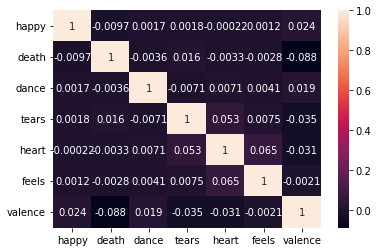

In [ ]:
# Assess correlation between terms and valence (https://www.kaggle.com/questions-and-answers/213194)
correlation_data = {vectorizer.tokenizer.token_to_word[i]: [entry[1][i] for entry in all_data] for i in range(len(all_data[0][1]))}
correlation_data['valence'] = [entry[0] for entry in all_data]
word_list = ['happy', 'death', 'dance', 'tears', 'heart', 'feels']
for word in word_list:
    print(word in vectorizer.tokenizer.word_to_token)
df = pd.DataFrame(correlation_data, columns=word_list+['valence'])
# vectorizer.tokenizer.token_to_word[i] for i in range(len(all_data[0][1]))

corrMatrix = df.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
for internal in all_data[int(cv/cv_count*len(all_data)):int((cv+1)/cv_count*len(all_data))]:
    print(internal[0])

print(training_labels_cv)

0.336
0.289
0.386
0.169
0.216
0.464
0.217
0.375
0.351
0.198
0.603
0.788
0.273
0.611
0.627
0.221
0.34
0.64
0.163
0.474
0.386
0.395
0.375
0.0444
0.685
0.963
0.526
0.218
0.217
0.304
0.203
0.758
0.558
0.605
0.464
0.523
0.955
0.377
0.2
0.202
0.141
0.65
0.226
0.187
0.714
0.12
0.699
0.585
0.64
0.338
0.248
0.425
0.772
0.0889
0.902
0.206
0.455
0.137
0.0796
0.797
0.865
0.697
0.315
0.203
0.673
0.554
0.317
0.178
0.71
0.0816
0.672
0.04
0.29
0.205
0.378
0.467
0.232
0.746
0.566
0.242
0.793
0.0396
0.498
0.527
0.227
0.34
0.308
0.506
0.239
0.846
0.346
0.614
0.582
0.383
0.0393
0.727
0.501
0.962
0.458
0.0786
0.432
0.415
0.651
0.783
0.483
0.372
0.569
0.641
0.468
0.406
0.606
0.48
0.315
0.218
0.343
0.28
0.224
0.134
0.249
0.33
0.559
0.313
0.242
0.253
0.431
0.679
0.631
0.248
0.038
0.727
0.348
0.0914
0.523
0.249
0.614
0.179
0.159
0.254
0.525
0.695
0.377
0.875
0.674
0.633
0.683
0.724
0.052
0.694
0.393
0.53
0.411
0.485
0.963
0.377
0.23
0.782
0.678
0.725
0.374
0.487
0.281
0.138
0.527
0.216
0.474
0.203
0.194
0.134


In [ ]:
# Initialize net, loss function, and optimizer
total_training_loss = 0
total_testing_loss = 0
total_baseline_loss = 0
total_best_guess = 0
for cv in range(cv_count):
    training_data, training_labels, test_data, test_labels = training_data_cv[cv], training_labels_cv[cv], test_data_cv[cv], test_labels_cv[cv]
    training_valence_mean = sum(training_labels)/len(training_labels)
    net = Net(len(training_data[0]))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Train network
    for epoch in range(50):  # loop over the dataset multiple times

        running_loss = 0.0
        running_sqrt_loss = 0.0
        baseline_loss = 0.0
        i = 0
        batch_size = 2**5
        while i < len(training_data):
            # get the inputs; data is a list of [inputs, labels]
            input, label = training_data[i:i+batch_size], training_labels[i:i+batch_size]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(input.float())
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += len(input)*loss.item()
            running_sqrt_loss += torch.sum(torch.abs(output - label))
            baseline_loss += torch.sum(torch.abs(label - training_valence_mean))

            i += batch_size
        
        # if epoch % 1 == 0:
        #     print("EPOCH", epoch)
        #     print("average epoch loss:", running_loss/len(training_data))
        #     print("average epoch raw loss:", running_sqrt_loss/len(training_data))
        #     print("average baseline raw loss:", baseline_loss/len(training_data))

    total_training_loss += running_sqrt_loss/len(training_data)
    print("EPOCH", epoch)
    print("average epoch loss:", running_loss/len(training_data))
    print("average epoch raw loss:", running_sqrt_loss/len(training_data))
    print("average baseline raw loss:", baseline_loss/len(training_data))
    print('Finished Training', len(training_data), 'examples')

    word_weights = []
    for w in range(len(net.layer1.weight[0])):
        word_weights.append((vectorizer.tokenizer.token_to_word[w], abs(net.layer1.weight[0][w]).item()))

    print(sorted(word_weights, key=lambda x: x[1], reverse=True))

    # Test network
    test_valence_mean = sum(test_labels)/len(test_labels)  # sum(test_labels)/len(test_labels)

    running_loss = 0.0
    running_sqrt_loss = 0.0
    baseline_loss = 0.0
    raw_model_losses = []
    raw_baseline_losses = []
    better_guess_frequency = 0
    for i in range(len(test_data)):
        # get the inputs; data is a list of [inputs, labels]
        input, label = test_data[i], test_labels[i]

        # forward + backward
        output = net(input.float())
        loss = criterion(output, label)
        running_loss += loss.item()
        running_sqrt_loss += torch.abs(output - label)
        raw_model_losses.append(torch.abs(output - label).item())
        baseline_loss += torch.abs(label-test_valence_mean)
        raw_baseline_losses.append(torch.abs(label-test_valence_mean).item())
        if torch.abs(output - label).item() < torch.abs(label-test_valence_mean).item():
            better_guess_frequency += 1

    total_baseline_loss += baseline_loss/len(test_data)
    total_testing_loss += running_sqrt_loss/len(test_data)
    total_best_guess += better_guess_frequency/len(test_data)
    print("average test loss:", running_loss/len(test_data))
    print("average sqrt(test loss):", running_sqrt_loss/len(test_data))
    print("average baseline raw loss:", baseline_loss/len(test_data))
    print("model loss std:", np.std(raw_model_losses))
    print("baseline loss std:", np.std(raw_baseline_losses))
    print("better guess frequency:", better_guess_frequency/len(test_data))
    print('Finished Testing', len(test_data), 'examples\n')

print("total training loss: ", total_training_loss/10)
print("total testing loss: ", total_testing_loss/10)
print("total baseline loss: ", total_baseline_loss/10)
print("total best guess: ", total_best_guess/10)


EPOCH 49
average epoch loss: 52.22043362709575
average epoch raw loss: tensor(4.2755, grad_fn=<DivBackward0>)
average baseline raw loss: tensor(20.2965)
Finished Training 8244 examples
[('alt', 0.5423020720481873), ('na', 0.5218070149421692), ('asked', 0.5033429265022278), ('ganz', 0.4801786541938782), ('dia', 0.47858718037605286), ('ten', 0.4324720799922943), ('ahora', 0.42386260628700256), ('nada', 0.4175603985786438), ('hab', 0.4145033359527588), ('lies', 0.4128302335739136), ('breath', 0.4098210334777832), ('x2', 0.40484046936035156), ('under', 0.4020026624202728), ("qu'un", 0.4008057117462158), ('save', 0.3930845558643341), ('staring', 0.3857541084289551), ('green', 0.3807113468647003), ('answer', 0.36931782960891724), ('bound', 0.36565667390823364), ('less', 0.36453777551651), ('art', 0.3629453778266907), ('kill', 0.3598659038543701), ('without', 0.3573716878890991), ('kingdom', 0.35523441433906555), ('feed', 0.35518214106559753), ('alive', 0.35486605763435364), ('taken', 0.35202

In [ ]:
final_songs_lyrics = []
dataset = 'unique_song_dataset'
with open('/content/lyrec_nlp/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs = [internal[0] for internal in final_songs]
final_lyrics = [internal[2] for internal in final_songs]

data_with_embedding = []

for index in range(len(final_songs)):
    internal_list = final_songs[index]
    embedding = processed_embeddings[index]
    internal_list.append(embedding)
    internal_list.append(net(torch.Tensor(embedding)))
    data_with_embedding.append(internal_list)

print(len(data_with_embedding))


# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(data_with_embedding, f2)

NameError: ignored

In [ ]:
# Pull lyrics

!pip install lyricsgenius

import lyricsgenius
import re

def pull_lyrics(songName, artist):

    token = "uZp3-3BY12KCvrTaSmi3Gv9EuTEAp-t4X4QOZ1OJbzWgVZakFrP4GF0Vsj0cz_Lu"
    genius = lyricsgenius.Genius(token)
    lyrics = ""
    while True:
        try:
            song =  genius.search_song(songName, artist)
            break
        except:
            pass

    # print(type(song))
    try:
        lyrics = song.lyrics
    except:
        lyrics = ""
    lyrics = lyrics[:-28] # remove 5EmbedShare URLCopyEmbedCopy from end
    lyrics = lyrics.lower()
    lyrics = lyrics.replace("\n"," ")  
    lyrics = lyrics.replace("\\'", "'")
    lyrics = lyrics.replace("\'", "'")
    lyrics = lyrics.replace(".", "")
    lyrics = lyrics.replace(",", "")
    lyrics = re.sub("[\(\[].*?[\)\]]", "", lyrics) #remove [] () and the contents in between

    return lyrics

     |████████████████████████████████| 59 kB 5.3 MB/s 


In [ ]:
print(pull_lyrics("The Way Life Goes", "Lil Uzi Vert"))

Searching for "The Way Life Goes" by Lil Uzi Vert...
Done.
 that's true  that's right  she's sipping moët and yeah i swear it get her wetter my louboutins new so my bottoms they is redder  no i'm not a rat but i'm all about my cheddar  just talked to your homie she said we should be together  gave me brain was so insane that i made her my header  if she ever call my phone you know i gotta dead her but i like that girl too much i wish i never met her   hello i was listening to this song it go like   i know it hurts sometimes but you'll get over it  you'll find another life to live  i swear that you'll get over it i know you're sad and tired you've got nothing left to give  you'll find another life to live  i know that you'll get over it    wish i never ever ever told you things i was only only trying to show you things  iced out heart on your neck tried to froze your ring i had to get me a new bitch to hold the pain we was in hawaii looking at the ring  she smiling happy but i'm laughin

In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'Country_Mix_evaluation'
with open('/content/lyrec_nlp/data/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs_lyrics = []

for i in range(len(final_songs)):
    internal = final_songs[i]
    lyrics = pull_lyrics(internal[0], internal[1])
    final_songs_lyrics.append(lyrics)
    final_songs[i][2] = lyrics


def get_embeddings(lyric_data):
  processed_embeddings = []
  common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
  common_word = set(common_word.split(" "))
  removed_index = set()
  for index in range(len(lyric_data)):
    song = lyric_data[index]
    words = song.split(" ")
    embedding = np.zeros(300)
    word_counter = 0
    non_vocab_counter = 0
    for word in words:
      if word not in common_word:
        try:
          word_embedding = model.get_vector(word)
          embedding += word_embedding
          word_counter += 1
        except:
          non_vocab_counter += 1
    if word_counter != 0:
      embedding = embedding/word_counter
    processed_embeddings.append(embedding)
    if non_vocab_counter>word_counter:
      removed_index.add(index)
  return processed_embeddings

print(final_songs_lyrics)
# Create Term Document matrix
# td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# # Convert to TF-IDF matrix
# tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
# print(tfidf_final_songs)

# for c in range(len(final_songs)):
#     tfidf_c = tfidf_final_songs[:,c].tolist()
#     final_songs[c].append(tfidf_c)
#     final_songs[c].append(net(torch.Tensor(tfidf_c)))


# Create Song Embeddings
final_embeddings = get_embeddings(final_songs_lyrics)

for c in range(len(final_songs)):
    final_songs[c].append(final_embeddings[c])
    final_songs[c].append(net(torch.Tensor(final_embeddings[c])))



# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

Searching for "Fancy Like" by Walker Hayes...
Done.
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Searching for "Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968" by Johnny Cash...
Done.
Searching for "One Too Many" by Keith Urban...
Done.
Searching for "Glad You Exist" by Dan + Shay...
Done.
Searching for "H.O.L.Y. - Acoustic" by Florida Georgia Lin

In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'Frank_Ocean_evaluation'
with open('/content/lyrec_nlp/data/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs_lyrics = []

for i in range(len(final_songs)):
    internal = final_songs[i]
    lyrics = pull_lyrics(internal[0], internal[1])
    final_songs_lyrics.append(lyrics)
    final_songs[i][2] = lyrics

def get_embeddings(lyric_data):
  processed_embeddings = []
  common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
  common_word = set(common_word.split(" "))
  removed_index = set()
  for index in range(len(lyric_data)):
    song = lyric_data[index]
    words = song.split(" ")
    embedding = np.zeros(300)
    word_counter = 0
    non_vocab_counter = 0
    for word in words:
      if word not in common_word:
        try:
          word_embedding = model.get_vector(word)
          embedding += word_embedding
          word_counter += 1
        except:
          non_vocab_counter += 1
    if word_counter != 0:
      embedding = embedding/word_counter
    processed_embeddings.append(embedding)
    if non_vocab_counter>word_counter:
      removed_index.add(index)
  return processed_embeddings

# Create Song Embeddings
final_embeddings = get_embeddings(final_songs_lyrics)

for c in range(len(final_songs)):
    final_songs[c].append(final_embeddings[c])
    final_songs[c].append(net(torch.Tensor(final_embeddings[c])))

print(final_songs_lyrics)
# Create Term Document matrix
# td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# # Convert to TF-IDF matrix
# tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
# print(tfidf_final_songs)

# for c in range(len(final_songs)):
#     tfidf_c = tfidf_final_songs[:,c].tolist()
#     final_songs[c].append(tfidf_c)
#     final_songs[c].append(net(torch.Tensor(tfidf_c)))

# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

Searching for "Thinkin Bout You" by Frank Ocean...
Done.
Searching for "Lost" by Frank Ocean...
Done.
Searching for "Slide (feat. Frank Ocean & Migos)" by Calvin Harris...
Done.
Searching for "In My Room" by Frank Ocean...
Done.
Searching for "Novacane" by Frank Ocean...
Done.
Searching for "Ivy" by Frank Ocean...
Done.
Searching for "Super Rich Kids" by Frank Ocean...
Done.
Searching for "Pink + White" by Frank Ocean...
Done.
Searching for "Chanel" by Frank Ocean...
Done.
Searching for "Nights" by Frank Ocean...
Done.
Searching for "911 / Mr. Lonely (feat. Frank Ocean & Steve Lacy)" by Tyler, The Creator...
Done.
Searching for "Swim Good" by Frank Ocean...
Done.
Searching for "Moon River" by Frank Ocean...
Done.
Searching for "Biking" by Frank Ocean...
Done.
Searching for "Forrest Gump" by Frank Ocean...
Done.
Searching for "Self Control" by Frank Ocean...
Done.
Searching for "Where This Flower Blooms (feat. Frank Ocean)" by Tyler, The Creator...
Done.
Searching for "White Ferrari" by

In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'Happy_Hits_evaluation'
with open('/content/lyrec_nlp/data/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs_lyrics = []

for i in range(len(final_songs)):
    internal = final_songs[i]
    lyrics = pull_lyrics(internal[0], internal[1])
    final_songs_lyrics.append(lyrics)
    final_songs[i][2] = lyrics

def get_embeddings(lyric_data):
  processed_embeddings = []
  common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
  common_word = set(common_word.split(" "))
  removed_index = set()
  for index in range(len(lyric_data)):
    song = lyric_data[index]
    words = song.split(" ")
    embedding = np.zeros(300)
    word_counter = 0
    non_vocab_counter = 0
    for word in words:
      if word not in common_word:
        try:
          word_embedding = model.get_vector(word)
          embedding += word_embedding
          word_counter += 1
        except:
          non_vocab_counter += 1
    if word_counter != 0:
      embedding = embedding/word_counter
    processed_embeddings.append(embedding)
    if non_vocab_counter>word_counter:
      removed_index.add(index)
  return processed_embeddings

# Create Song Embeddings
final_embeddings = get_embeddings(final_songs_lyrics)

for c in range(len(final_songs)):
    final_songs[c].append(final_embeddings[c])
    final_songs[c].append(net(torch.Tensor(final_embeddings[c])))

print(final_songs_lyrics)
# Create Term Document matrix
# td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# # Convert to TF-IDF matrix
# tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
# print(tfidf_final_songs)

# for c in range(len(final_songs)):
#     tfidf_c = tfidf_final_songs[:,c].tolist()
#     final_songs[c].append(tfidf_c)
#     final_songs[c].append(net(torch.Tensor(tfidf_c)))

# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

Searching for "Shivers" by Ed Sheeran...
Done.
Searching for "Fly Away" by Tones And I...
Done.
Searching for "Summer of Love (Shawn Mendes & Tainy)" by Shawn Mendes...
Done.
Searching for "Run" by OneRepublic...
Done.
Searching for "The Best Days (feat. Tabitha)" by Sam Feldt...
Done.
Searching for "Anyone" by Justin Bieber...
Done.
Searching for "Love You Better" by John De Sohn...
Searching for "Love You Better" by John De Sohn...
Searching for "Love You Better" by John De Sohn...
Done.
Searching for "Lasting Lover" by Sigala...
Done.
Searching for "At Least I Had Fun" by Martin Jensen...
Done.
Searching for "Pick Me Up" by Sam Feldt...
Done.
Searching for "Good Vibes" by HRVY...
Done.
Searching for "Cloudy Day" by Tones And I...
Done.
Searching for "Love Me Now (feat. Zoe Wees)" by Kygo...
Done.
Searching for "Smile" by Benjamin Ingrosso...
Done.
Searching for "You for Me" by Sigala...
Done.
Searching for "Remember This" by Jonas Brothers...
Done.
Searching for "Never Love You Agai

In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'RapCaviar_evaluation'
with open('/content/lyrec_nlp/data/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs_lyrics = []

for i in range(len(final_songs)):
    internal = final_songs[i]
    lyrics = pull_lyrics(internal[0], internal[1])
    final_songs_lyrics.append(lyrics)
    final_songs[i][2] = lyrics


def get_embeddings(lyric_data):
  processed_embeddings = []
  common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
  common_word = set(common_word.split(" "))
  removed_index = set()
  for index in range(len(lyric_data)):
    song = lyric_data[index]
    words = song.split(" ")
    embedding = np.zeros(300)
    word_counter = 0
    non_vocab_counter = 0
    for word in words:
      if word not in common_word:
        try:
          word_embedding = model.get_vector(word)
          embedding += word_embedding
          word_counter += 1
        except:
          non_vocab_counter += 1
    if word_counter != 0:
      embedding = embedding/word_counter
    processed_embeddings.append(embedding)
    if non_vocab_counter>word_counter:
      removed_index.add(index)
  return processed_embeddings

# Create Song Embeddings
final_embeddings = get_embeddings(final_songs_lyrics)

for c in range(len(final_songs)):
    final_songs[c].append(final_embeddings[c])
    final_songs[c].append(net(torch.Tensor(final_embeddings[c])))

print(final_songs_lyrics)
# Create Term Document matrix
# td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# # Convert to TF-IDF matrix
# tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
# print(tfidf_final_songs)

# for c in range(len(final_songs)):
#     tfidf_c = tfidf_final_songs[:,c].tolist()
#     final_songs[c].append(tfidf_c)
#     final_songs[c].append(net(torch.Tensor(tfidf_c)))

# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

Searching for "Don’t Play (with Lil Baby)" by Polo G...
Done.
Searching for "Too Easy (Remix) [feat. Future & Roddy Ricch]" by Gunna...
Done.
Searching for "Jumpin (feat. Polo G)" by NLE Choppa...
Done.
Searching for "Bubbly (with Drake & Travis Scott)" by Young Thug...
Done.
Searching for "Young N Dumb" by Polo G...
Done.
Searching for "LLC (feat. Moneybagg Yo)" by Money Man...
Done.
Searching for "ESCAPE PLAN" by Travis Scott...
Done.
Searching for "ROOF" by DaBaby...
Done.
Searching for "By Your Side" by Rod Wave...
Done.
Searching for "MAFIA" by Travis Scott...
Searching for "MAFIA" by Travis Scott...
Searching for "MAFIA" by Travis Scott...
Done.
Searching for "Ambition For Cash" by Key Glock...
Done.
Searching for "family ties (with Kendrick Lamar)" by Baby Keem...
Done.
Searching for "Black Man in America" by Polo G...
Done.
Searching for "Sinister (feat. Lil Wayne)" by Cordae...
Done.
Searching for "Hot (feat. Moneybagg Yo)" by Meek Mill...
Done.
Searching for "Switches & Dracs

In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'Sad_Hour_evaluation'
with open('/content/lyrec_nlp/data/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs_lyrics = []

for i in range(len(final_songs)):
    internal = final_songs[i]
    lyrics = pull_lyrics(internal[0], internal[1])
    final_songs_lyrics.append(lyrics)
    final_songs[i][2] = lyrics

def get_embeddings(lyric_data):
  processed_embeddings = []
  common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
  common_word = set(common_word.split(" "))
  removed_index = set()
  for index in range(len(lyric_data)):
    song = lyric_data[index]
    words = song.split(" ")
    embedding = np.zeros(300)
    word_counter = 0
    non_vocab_counter = 0
    for word in words:
      if word not in common_word:
        try:
          word_embedding = model.get_vector(word)
          embedding += word_embedding
          word_counter += 1
        except:
          non_vocab_counter += 1
    if word_counter != 0:
      embedding = embedding/word_counter
    processed_embeddings.append(embedding)
    if non_vocab_counter>word_counter:
      removed_index.add(index)
  return processed_embeddings

# Create Song Embeddings
final_embeddings = get_embeddings(final_songs_lyrics)

for c in range(len(final_songs)):
    final_songs[c].append(final_embeddings[c])
    final_songs[c].append(net(torch.Tensor(final_embeddings[c])))

print(final_songs_lyrics)
# Create Term Document matrix
# td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# # Convert to TF-IDF matrix
# tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
# print(tfidf_final_songs)

# for c in range(len(final_songs)):
#     tfidf_c = tfidf_final_songs[:,c].tolist()
#     final_songs[c].append(tfidf_c)
#     final_songs[c].append(net(torch.Tensor(tfidf_c)))

# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

Searching for "Nothing New (feat. Phoebe Bridgers) (Taylor’s Version) (From The Vault)" by Taylor Swift...
Done.
Searching for "Set Me Free" by Joshua Bassett...
Done.
Searching for "not over you" by joan...
Done.
Searching for "All Too Well (Sad Girl Autumn Version) - Recorded at Long Pond Studios" by Taylor Swift...
Done.
Searching for "Nights Like This" by Josh Golden...
Done.
Searching for "Missing You Sucks" by Clara Mae...
Done.
Searching for "Year From Now" by Katelyn Tarver...
Done.
Searching for "People Watching" by Conan Gray...
Done.
Searching for "South Dakota" by JORDY...
Done.
Searching for "Life of the Party" by Sofia Mills...
Done.
Searching for "All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)" by Taylor Swift...
Done.
Searching for "Happier Than Ever" by Billie Eilish...
Done.
Searching for "Remember That Night?" by Sara Kays...
Done.
Searching for "Never the 1" by ROSIE...
Done.
Searching for "What A Time (feat. Niall Horan)" by Julia Michaels...


In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'Xxxtentacion_evaluation'
with open('/content/lyrec_nlp/data/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)

final_songs_lyrics = []
for i in range(len(final_songs)):
    internal = final_songs[i]
    lyrics = pull_lyrics(internal[0], internal[1])
    final_songs_lyrics.append(lyrics)
    final_songs[i][2] = lyrics

def get_embeddings(lyric_data):
  processed_embeddings = []
  common_word = "ourselves hers between yourself but again there about once during out very having with they own an be some for do its yours such into of most itself other off is am or who as from him each the themselves until below are we these your his through don nor me were her more himself this down should our their while above both up to ours had she all no when at any before them same and been have in will on does yourselves then that because what over why so can did not now under he you herself has just where too only myself which those i after few whom being if theirs my against a by doing it how further was here than" 
  common_word = set(common_word.split(" "))
  removed_index = set()
  for index in range(len(lyric_data)):
    song = lyric_data[index]
    words = song.split(" ")
    embedding = np.zeros(300)
    word_counter = 0
    non_vocab_counter = 0
    for word in words:
      if word not in common_word:
        try:
          word_embedding = model.get_vector(word)
          embedding += word_embedding
          word_counter += 1
        except:
          non_vocab_counter += 1
    if word_counter != 0:
      embedding = embedding/word_counter
    processed_embeddings.append(embedding)
    if non_vocab_counter>word_counter:
      removed_index.add(index)
  return processed_embeddings

# Create Song Embeddings
final_embeddings = get_embeddings(final_songs_lyrics)

for c in range(len(final_songs)):
    final_songs[c].append(final_embeddings[c])
    final_songs[c].append(net(torch.Tensor(final_embeddings[c])))

print(final_songs_lyrics)
# Create Term Document matrix
# td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# # Convert to TF-IDF matrix
# tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
# print(tfidf_final_songs)

# for c in range(len(final_songs)):
#     tfidf_c = tfidf_final_songs[:,c].tolist()
#     final_songs[c].append(tfidf_c)
#     final_songs[c].append(net(torch.Tensor(tfidf_c)))

# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_embedding_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

Searching for "SAD!" by XXXTENTACION...
Done.
Searching for "Jocelyn Flores" by XXXTENTACION...
Done.
Searching for "Roll in Peace (feat. XXXTENTACION)" by Kodak Black...
Done.
Searching for "Look At Me!" by XXXTENTACION...
Done.
Searching for "Falling Down - Bonus Track" by Lil Peep...
Done.
Searching for "Moonlight" by XXXTENTACION...
Done.
Searching for "Fuck Love (feat. Trippie Redd)" by XXXTENTACION...
Done.
Searching for "I Don't Wanna Do This Anymore" by XXXTENTACION...
Done.
Searching for "Again (feat. XXXTENTACION)" by Noah Cyrus...
Done.
Searching for "changes" by XXXTENTACION...
Done.
Searching for "Everybody Dies In Their Nightmares" by XXXTENTACION...
Searching for "Everybody Dies In Their Nightmares" by XXXTENTACION...
Searching for "Everybody Dies In Their Nightmares" by XXXTENTACION...
Searching for "Everybody Dies In Their Nightmares" by XXXTENTACION...
Done.
Searching for "YuNg BrAtZ" by XXXTENTACION...
Done.
Searching for "Gospel" by Rich Brian...
Done.
Searching for

In [ ]:
# Generate final embeddings for unlabeled songs
final_songs_lyrics = []
dataset = 'unique_song_dataset'
with open('/content/lyrec_nlp/' + dataset + '.pkl', 'rb') as f:
    final_songs = pickle.load(f)
print(final_songs[0])
# break
final_songs_lyrics = []

for i in range(len(final_songs)):
    internal = final_songs[i][0]
    print(internal)
    final_songs_lyrics.append(internal[2])

print(final_songs_lyrics)
# Create Term Document matrix
td_matrix_final_songs = vectorizer.transform(final_songs_lyrics).T

# Convert to TF-IDF matrix
tfidf_final_songs = transform_tfidf(td_matrix_final_songs, idf, evaluation=True)
print(tfidf_final_songs)

for c in range(len(final_songs)):
    tfidf_c = tfidf_final_songs[:,c].tolist()
    final_songs[c].append(tfidf_c)
    final_songs[c].append(net(torch.Tensor(tfidf_c)))

# Save extended final_songs reps to pickle file
with open('/content/lyrec_nlp/data/' + dataset + '_extended.pkl', 'wb') as f2:
    pickle.dump(final_songs, f2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[7.48102459e-02 2.03680451e-01 1.13034459e-01 ... 3.54939123e-02
  5.07835976e-02 2.62108891e-02]
 [3.10037457e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.99442948e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import torch

def cluster_embeddings(data, pca_df):
    k_means = KMeans(n_clusters= 3)
    
    label = k_means.fit_predict(data)
    u_labels = np.unique(label)

    for u in u_labels:
        plt.scatter(pca_df[label==u , 0] , pca_df[label==u , 1] , label = u)
    plt.legend()
    plt.show()

    

def get_reduced_embedding(data, plot_embedding = False):
    label = []
    embeddings = []
    freq = {}
    for info in data:
        artist = info[1]
        if artist not in freq:
            freq[artist] = 1
        else:
            freq[artist] += 1
        label.append(artist)
        embeddings.append(info[5])

    pca = PCA(2)
    pca_df = pca.fit_transform(embeddings)
    if plot_embedding:
        label = np.array(label)
        u_labels = []
        for _ in range(8):
            max_artist = max(freq, key = freq.get)
            freq.pop(max_artist)
            u_labels.append(max_artist)
            if freq == {}:
                break
        for u in u_labels:
            ix = np.where(label==u)
            plt.scatter(pca_df[ix, 0] , pca_df[ix, 1] , label = u)
        plt.legend()
        plt.show()
    return pca_df


def average_cosine_distance(data):
    total_pairs = 0
    total_distance = 0
    for i in range(len(data)-1):
        for j in range(i+1, len(data)):
            total_pairs += 1
            embedding_1 = data[i]
            embedding_2 = data[j]
            dot_product = np.dot(embedding_1, embedding_2)
            norm_1 = np.linalg.norm(embedding_1)
            norm_2 = np.linalg.norm(embedding_2)
            if norm_1 == 0:
                norm_1 = 0.0000000001
            if norm_2 == 0:
                norm_2 = 0.0000000001
            distance = dot_product/(norm_1*norm_2)
            total_distance += distance
    # print(total_pairs)
    return total_distance/total_pairs



if __name__ == "__main__":
    # with open('eval_data/Happy_Hits_evaluation_extended.pkl', 'rb') as f:
    #     with open('../eval_data/Sad_Hour_evaluation_extended.pkl', 'rb') as f2:

    data = final_songs
    # with open('/content/lyrec_nlp/data/unique_song_dataset_extended.pkl', 'rb') as f:
        # data = pickle.load(f)
    embeddings = []
    all_scores = []
    print(len(data))
    for song_list in data:
        valence = song_list[2].detach().tolist()[0] - 50
        # valence = song_list[3]*100 - 50
        embeddings.append(song_list[1]+ [valence])
        # print(len(embeddings))
            # pca_df = get_reduced_embedding(data, True)
            # cluster_embeddings(embeddings, pca_df)
    print(average_cosine_distance(embeddings))


    # with open('unique_song_dataset_extended.pkl', 'rb') as f:
    #         # data = pickle.load(f)
    #         data = pickle.load(f)
    #         embeddings = []
    #         all_scores = []
    #         for song_list in data:
    #             valence = song_list[2].detach().tolist()[0] - 50
    #             # valence = song_list[3]*100 - 50
    #             embeddings.append(song_list[1]+ [valence])

    #         # pca_df = get_reduced_embedding(data, True)
    #         # cluster_embeddings(embeddings, pca_df)
    #         print (average_cosine_distance(embeddings))

    




9159
0.034637372030124854
